In [ ]:
import hashlib
import os
import pickle
from hwcomponents_cacti import CactiSRAM
from hwcomponents_library import AladdinAdder, AladdinMultiplier

from fastfusion.frontend.architecture import Memory
from fastfusion.frontend.specification import Specification
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.simanneal.wrappers import join_sims

import copy
import time
from fastfusion import Specification
from fastfusion.mapper.FFM.exploration.metrics import Metrics
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_sims
from fastfusion.mapper.FFM.joining.sim import SIM
from fastfusion.mapper.FFM.joining.simexplore import join_sims
import fastfusion.mapper.FFM.exploration.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM.exploration.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM.exploration.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM.pareto import PartialMappings

# TODO: area is an alias for get_area
# TODO: Separate energy and area
# TODO: Move scaling into main hwcomponents repo
# TODO: Function that just returns the hwcomponents component
# TODO: Is all the initial right consolidation necessary?
# TODO: Datawidth calculation for energy

# TODO: Reference specific tensor names in constraints, even if those tensors are not in
# a particular Einsum. Also have the error mrssages for parsing errors list which Einsum
# failed. Einsums that aren't in the tensor should resolve to NotInThisEinsum(), which =
# nothing.

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.
# TODO: Make the mapping return an object that supports union operators and stuff

spec = Specification.from_yaml(
    f"architecture/four_level.arch.yaml",
    "workloads/mha_full.workload.yaml",
    "workloads/mha_full.renames.yaml",
)

adder = AladdinAdder(technology="7nm", width=16)
multiplier = AladdinMultiplier(technology="7nm", width=8)
mac_area = adder.get_area() + multiplier.get_area()

print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")
print(f"COMPUTE ENERGY / 8 ????????????")

def get_fused_mappings(
        spec: Specification, 
        n_pes,
        local_buffer_model,
        global_buffer_model,
        tagger=None, 
        # fuse=True,
        parameterization="",
        return_mappings=False,
    ) -> PartialMappings:
    cachekey = (n_pes, local_buffer_model.width, local_buffer_model.depth, global_buffer_model.width, global_buffer_model.depth, parameterization)
    fname = parameterization + " " + hashlib.md5(str(cachekey).encode()).hexdigest()
    if os.path.exists(f"cache/{fname}.pkl"):
        print(f"Loading from cache: {fname}")
        mappings = pickle.load(open(f"cache/{fname}.pkl", "rb"))
        if return_mappings:
            return mappings
        return (mappings.data["metric_Energy"] * mappings.data["metric_Latency"]).min(), mappings
    spec = copy.deepcopy(spec)
    local_buffer: Memory = spec.architecture.nodes["LocalBuffer"]
    local_buffer.attributes.size = local_buffer_model.width * local_buffer_model.depth
    global_buffer: Memory = spec.architecture.nodes["GlobalBuffer"]
    global_buffer.attributes.size = global_buffer_model.width * global_buffer_model.depth
    for target, model in [(local_buffer, local_buffer_model), (global_buffer, global_buffer_model)]:
        target.actions["read"].arguments.energy = model.read() / model.width
        target.actions["write"].arguments.energy = model.write() / model.width
    main_memory: Memory = spec.architecture.nodes["MainMemory"]
    if parameterization == "Unfused":
        main_memory.constraints.storage.keep = "All()"
    elif parameterization == "FlashAttention":
        main_memory.constraints.storage.keep = "All() - QK - Q - K - V - I"
        main_memory.constraints.storage.bypass = "QK | Q | K | V | I"
    elif parameterization == "Fuse I":
        main_memory.constraints.storage.keep = "All() - I"
        main_memory.constraints.storage.bypass = "I"
    elif parameterization == "FFM":
        main_memory.constraints.storage.keep = "~Intermediates()"# - I - Q - K - V"# | AV | Z "
        main_memory.constraints.storage.bypass = "Q | K | V | I"#Q | K | V | I"# | QK | FFA"
        pass
    else:
        assert False, f"Parameterization {parameterization} not supported"
    register: Memory = spec.architecture.nodes["Register"]
    register.spatial.fanout["X"] = n_pes
    register.spatial.fanout["Y"] = n_pes
    
    spec.estimate_energy_area()
    flattened_architecture = spec.get_flattened_architecture()
    t0 = time.time()
    sims, decompress_data = get_sims(spec, flattened_architecture, tagger=tagger, metrics=Metrics.LATENCY | Metrics.ENERGY | Metrics.PER_COMPONENT_ENERGY) # metrics=Metrics.ENERGY | # | Metrics.PER_COMPONENT_ENERGY)
    pmapping_time = time.time() - t0
    total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
    n_pareto_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
    print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pareto_optimal_mappings} pareto optimal mappings ({n_pareto_optimal_mappings / total_pmappings*100:.2f}% of total).')
    t0 = time.time()
    mappings = join_sims(sims, spec, flattened_architecture)
    join_time = time.time() - t0
    mappings.decompress(decompress_data)
    print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")
    pickle.dump(mappings, open(f"cache/{fname}.pkl", "wb"))
    if return_mappings:
        return mappings
    return (mappings.data["metric_Energy"] * mappings.data["metric_Latency"]).min(), mappings

print(f'Overall area budget: {area_budget * 1e6} mm^2')

parameterization2edp = {}
parameterization2mappings = {}

parameterizations = ["FFM", "Unfused"]#, "FlashAttention"]#, "FlashAttention", "Unfused"]

for glb_MB in [8]:#, 64, 32, 16]:#,16]:#16, 32, 64, 128]: # [16, 32, 64, 128]: # 16, 64
    cur_area_budget = area_budget
    glb_size = glb_MB * 1024 * 1024 * 8
    glb = CactiSRAM(technology="7nm", width=1024, depth=glb_size // 1024)
    cur_area_budget -= glb.get_area()
    # for sram_MB in [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:
    for sram_MB in [4]:#, 1, 0.25]:#,0.5]:#[0.5,1,2,4]: # [0.25, 1, 4]: # 0.125, 0.5, 2
        sram_size = sram_MB * 1024 * 1024 * 8
        llb = CactiSRAM(technology="7nm", width=128, depth=sram_size // 128)
        remaining_area = cur_area_budget / 4 - llb.get_area() # Per-MXU
        if remaining_area < 0:
            break
        mac_dims = int((remaining_area / mac_area) ** 0.5)
        print(f"Global buffer: {glb_MB} MB, Local buffer: {sram_MB} MB, MAC dims: {mac_dims}x{mac_dims}")
        print(f'GLB read energy: {glb.read()}. LLB read energy: {llb.read()}')
        
        for parameterization in parameterizations: # "fuse"
            x, mappings = get_fused_mappings(
                spec,
                mac_dims,
                llb,
                glb,
                parameterization=parameterization,
            )
            if x != 0:
                parameterization2edp[f"{parameterization} {glb_MB}MB {sram_MB}MB {mac_dims}x{mac_dims}"] = x
                parameterization2mappings[f"{parameterization} {glb_MB}MB {sram_MB}MB {mac_dims}x{mac_dims}"] = mappings

INFO        Loading yaml file architecture/four_level.arch.yaml
INFO        Found top key variables in architecture/four_level.arch.yaml
INFO        Found top key architecture in architecture/four_level.arch.yaml
INFO        Found top key component_classes in architecture/four_level.arch.yaml
INFO        Loading yaml file workloads/mha_full.workload.yaml
INFO        Found top key workload in workloads/mha_full.workload.yaml
INFO        Loading yaml file workloads/mha_full.renames.yaml
INFO        Found top key renames in workloads/mha_full.renames.yaml
WARNING     Loading configuration file from /root/.config/fastfusion/config.yaml


COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
COMPUTE ENERGY / 8 ????????????
Overall area budget: 39.657475727216784 mm^2


INFO        Calculated "614e9 * 8 / 1.05e9" = 4678.0952380952385.
INFO        Calculated "0.84e-12 / 8" = 1.05e-13.
INFO        Calculated "0.5" = 0.5.


Global buffer: 8 MB, Local buffer: 4 MB, MAC dims: 399x399
GLB read energy: 4.0725446487730497e-10. LLB read energy: 4.2315915388286673e-11
By default metrics optimizes for energy and latency.We should change to just energy or just latency at some point.


Generating storage and loop choices for Einsum I: 6it [00:00, 87.54it/s]
Generating Pmappings for I:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_77828/1760616645.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend()


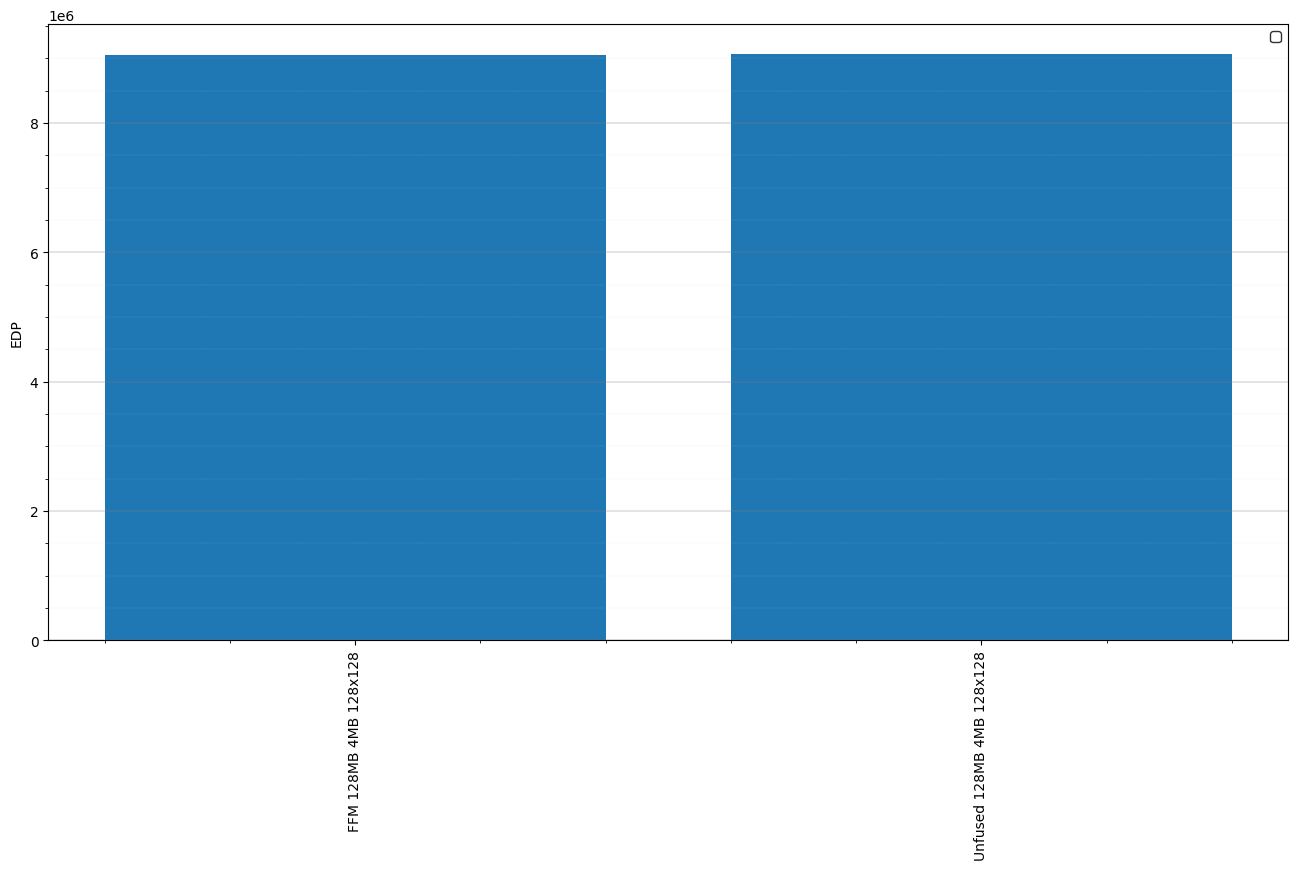

In [2]:
import matplotlib.pyplot as plt
plt.style.use('default')
# plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)
    legend = ax.legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    if ax.get_legend() is None:
        legend = ax.legend(fontsize=24, ncol=2)
    ax.minorticks_on()
    ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')
    

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label)
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        plt.legend(loc='upper right', fontsize=10)
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()
print()
make_bar_chart(
    parameterization2edp,
    title=None,
    xlabel=None,
    ylabel="EDP",
    y_scale='linear'
)

In [3]:
# # glb_MB = 128
# # sram_MB = 4
# # parameterization = ""

# # cur_area_budget = area_budget
# # glb_size = glb_MB * 1024 * 1024 * 8
# # glb = CactiSRAM(technology="7nm", width=1024, depth=glb_size // 1024)
# # cur_area_budget -= glb.get_area()
# # # for sram_MB in [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:
# # sram_size = sram_MB * 1024 * 1024 * 8
# # llb = CactiSRAM(technology="7nm", width=128, depth=sram_size // 128)
# # remaining_area = cur_area_budget / 4 - llb.get_area() # Per-MXU
# # mac_dims = int((remaining_area / mac_area) ** 0.5)
# # print(f"Global buffer: {glb_MB} MB, Local buffer: {sram_MB} MB, MAC dims: {mac_dims}x{mac_dims}")
# # print(f'GLB read energy: {glb.read()}. LLB read energy: {llb.read()}')

from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_per_tensor_size, get_num_computes
for tensor, size in sorted(get_per_tensor_size(spec).items(), key=lambda x: x[1], reverse=True):
    print(f"{tensor}: {size}")
print(f"Number of computes: {get_num_computes(spec)}")

AV
WV
WFFA
K
V
WK
WFFB
Z
FFB
I_in
I
WQ
QK
FFA
Q
WZ
QK: 134217728
WFFA: 67108864
WFFB: 67108864
FFA: 33554432
WV: 16777216
WK: 16777216
WQ: 16777216
WZ: 16777216
AV: 8388608
K: 8388608
V: 8388608
Z: 8388608
FFB: 8388608
I_in: 8388608
I: 8388608
Q: 8388608
Number of computes: 446684987392


In [4]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

parameterization2latencycols: list[dict[str, float]] = []
for p, mappings in parameterization2mappings.items():
    mappings._data = mappings.data.sort_values(by="metric_Energy", ascending=True)
    rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)

    row = {
        "Parameterization": p,
    }
    for col in mappings.data.columns:
        print(f'{col}: {mappings.data.iloc[0][col]}')
        # if "Latency" in col:
        # if "metric_Latency" in col:
        if "Energy" in col:
        # if "metric_Energy" in col:
            row[col] = mappings.data.iloc[0][col]
    parameterization2latencycols.append(row)

    # from fastfusion.mapper.FFM.visualization import make_mapping
    # from IPython.display import SVG
    # newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
    # for col in mappings.data.columns:
    #     print(f'{col}: {mappings.data.iloc[0][col]}')

    # display(SVG(newmapping.render()))
    
from pandas import DataFrame
df = DataFrame(parameterization2latencycols)
import pandas as pd
pd.set_option('display.max_columns', None)
df
    
# {'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1
# TODO: Re-add -1 to the mapper one eisnum freenig
# compatibility2sims['Matmul1']["{'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1"]
# Above 1: 8192
# Above 2: 8321
# compatibility2sims['Matmul2']["{'n1'}-1 || [GlobalBuffer] T1 sz 0 above 1, [GlobalBuffer] T2 sz 0 above 0"]

FFB__tile_shape0: 1.0
FFB__tile_shape1: 2048.0
FFB__tile_shape2: 16384.0
FFB__tile_shape3: 1.0
FFB__tile_shape4: 2048.0
FFB__tile_shape5: 1.0
FFB__tile_shape6: 1.0
FFB__tile_shape7: 2048.0
FFB__tile_shape8: 8.0
FFB__tile_shape9: 1.0
FFB__tile_shape10: 1.0
FFB__tile_shape11: 16.0
FFB__tile_shape12: 1.0
FFB__tile_shape13: 1.0
FFB__tile_shape14: 1.0
FFB__tile_shape15: 1.0
FFB__tile_shape16: 1.0
FFB__tile_shape17: 1.0
FFBRESOURCE_Register_LEVEL_2: nan
FFBRESOURCE_LocalBuffer_LEVEL_2: nan
FFBRESOURCE_GlobalBuffer_LEVEL_1: nan
FFBRESOURCE_GlobalBuffer_LEVEL_2: nan
FFBRESOURCE_MainMemory_LEVEL_0: 603979776
FFBmetric_Latency: 8388608.0
FFBcompute_Latency: 8388608.0
FFBLocalBuffer_Latency: 0
FFBRegister_Latency: 0
FFBMainMemory_Latency: 129108.05472285078
FFBGlobalBuffer_Latency: 0
FFBmetric_Energy: 0.40669325012747787
FFB('LocalBuffer', 'read')_Energy: 0.0908727363464972
FFB('LocalBuffer', 'write')_Energy: 0.07930064187814245
FFB('Register', 'read')_Energy: 0
FFB('Register', 'write')_Energy: 0

,Parameterization,FFBmetric_Energy,"FFB('LocalBuffer', 'read')_Energy","FFB('LocalBuffer', 'write')_Energy","FFB('Register', 'read')_Energy","FFB('Register', 'write')_Energy","FFB('MainMemory', 'read')_Energy","FFB('MainMemory', 'write')_Energy","FFB('GlobalBuffer', 'read')_Energy","FFB('GlobalBuffer', 'write')_Energy","FFB('MAC', 'compute')_Energy",FFAmetric_Energy,"FFA('LocalBuffer', 'read')_Energy","FFA('LocalBuffer', 'write')_Energy","FFA('Register', 'read')_Energy","FFA('Register', 'write')_Energy","FFA('MainMemory', 'read')_Energy","FFA('MainMemory', 'write')_Energy","FFA('GlobalBuffer', 'read')_Energy","FFA('GlobalBuffer', 'write')_Energy","FFA('MAC', 'compute')_Energy",Zmetric_Energy,"Z('Register', 'read')_Energy","Z('Register', 'write')_Energy","Z('LocalBuffer', 'read')_Energy","Z('LocalBuffer', 'write')_Energy","Z('MainMemory', 'read')_Energy","Z('MainMemory', 'write')_Energy","Z('GlobalBuffer', 'read')_Energy","Z('GlobalBuffer', 'write')_Energy","Z('MAC', 'compute')_Energy",AVmetric_Energy,"AV('LocalBuffer', 'read')_Energy","AV('LocalBuffer', 'write')_Energy","AV('Register', 'read')_Energy","AV('Register', 'write')_Energy","AV('GlobalBuffer', 'read')_Energy","AV('GlobalBuffer', 'write')_Energy","AV('MainMemory', 'read')_Energy","AV('MainMemory', 'write')_Energy","AV('MAC', 'compute')_Energy",QKmetric_Energy,"QK('LocalBuffer', 'read')_Energy","QK('LocalBuffer', 'write')_Energy","QK('Register', 'read')_Energy","QK('Register', 'write')_Energy","QK('GlobalBuffer', 'read')_Energy","QK('GlobalBuffer', 'write')_Energy","QK('MAC', 'compute')_Energy",Qmetric_Energy,"Q('Register', 'read')_Energy","Q('Register', 'write')_Energy","Q('LocalBuffer', 'read')_Energy","Q('LocalBuffer', 'write')_Energy","Q('MainMemory', 'read')_Energy","Q('MainMemory', 'write')_Energy","Q('GlobalBuffer', 'read')_Energy","Q('GlobalBuffer', 'write')_Energy","Q('MAC', 'compute')_Energy",Kmetric_Energy,"K('LocalBuffer', 'read')_Energy","K('LocalBuffer', 'write')_Energy","K('Register', 'read')_Energy","K('Register', 'write')_Energy","K('MainMemory', 'read')_Energy","K('MainMemory', 'write')_Energy","K('GlobalBuffer', 'read')_Energy","K('GlobalBuffer', 'write')_Energy","K('MAC', 'compute')_Energy",Vmetric_Energy,"V('LocalBuffer', 'read')_Energy","V('LocalBuffer', 'write')_Energy","V('Register', 'read')_Energy","V('Register', 'write')_Energy","V('MainMemory', 'read')_Energy","V('MainMemory', 'write')_Energy","V('GlobalBuffer', 'read')_Energy","V('GlobalBuffer', 'write')_Energy","V('MAC', 'compute')_Energy",Imetric_Energy,"I('GlobalBuffer', 'read')_Energy","I('GlobalBuffer', 'write')_Energy","I('LocalBuffer', 'read')_Energy","I('LocalBuffer', 'write')_Energy","I('MainMemory', 'read')_Energy","I('MainMemory', 'write')_Energy","I('MAC', 'compute')_Energy",metric_Energy,"QK('MainMemory', 'read')_Energy","QK('MainMemory', 'write')_Energy"
0,FFM 128MB 4MB 128x128,0.406693,0.090873,0.079301,0,0,0.000472,0.000059,0.221531,0.000028,0.014431,0.406728,0.090873,0.079308,0,0,0.000531,0.000000,0.221517,0.000069,0.014431,0.101941,0,0,0.022718,0.019827,0.000295,0.000059,0.055393,0.000041,0.003608,0.050881,0.011359,0.009915,0,0,0.027717,0.000028,0.000000,0.000059,0.001804,0.051037,0.011359,0.009951,0,0,0.027703,0.000220,0.001804,0.101664,0,0,0.022718,0.019827,0.000118,0.000000,0.055379,0.000014,0.003608,0.101664,0.022718,0.019827,0,0,0.000118,0.000000,0.055379,0.000014,0.003608,0.101664,0.022718,0.019827,0,0,0.000118,0.000000,0.055379,0.000014,0.003608,0.000109,0.000014,0.000028,0.000003,0.000005,0.000059,0.000000,8.808038e-07,1.322381,NaN,NaN
1,Unfused 128MB 4MB 128x128,0.407456,0.090873,0.079301,0,0,0.001179,0.000059,0.221531,0.000083,0.014431,0.407545,0.090873,0.079308,0,0,0.001003,0.000236,0.221571,0.000124,0.014431,0.101941,0,0,0.022718,0.019827,0.000295,0.000059,0.055393,0.000041,0.003608,0.052149,0.011359,0.009915,0,0,0.027703,0.000248,0.001061,0.000059,0.001804,0.052595,0.011359,0.009951,0,0,0.027906,0.000454,0.001804,0.101941,0,0,0.022718,0.019827,0.000295,0.000059

Loading from cache: FFM e7587cf921a2eb76dfecd9d2444e4ca7
FFB__tile_shape0: 1.0
FFB__tile_shape1: 2048.0
FFB__tile_shape2: 16384.0
FFB__tile_shape3: 1.0
FFB__tile_shape4: 512.0
FFB__tile_shape5: 1.0
FFB__tile_shape6: 1.0
FFB__tile_shape7: 512.0
FFB__tile_shape8: 32.0
FFB__tile_shape9: 1.0
FFB__tile_shape10: 1.0
FFB__tile_shape11: 4.0
FFB__tile_shape12: 1.0
FFB__tile_shape13: 1.0
FFB__tile_shape14: 1.0
FFB__tile_shape15: 1.0
FFB__tile_shape16: 1.0
FFB__tile_shape17: 1.0
FFBRESOURCE_Register_LEVEL_2: nan
FFBRESOURCE_LocalBuffer_LEVEL_2: nan
FFBRESOURCE_GlobalBuffer_LEVEL_1: nan
FFBRESOURCE_GlobalBuffer_LEVEL_2: nan
FFBRESOURCE_MainMemory_LEVEL_0: 603979776
FFBmetric_Latency: 2097152.0
FFBcompute_Latency: 2097152.0
FFBLocalBuffer_Latency: 0
FFBRegister_Latency: 0
FFBMainMemory_Latency: 129108.05472285078
FFBGlobalBuffer_Latency: 0
FFBmetric_Energy: 0.40810857606923784
FFB('LocalBuffer', 'read')_Energy: 0.0908727363464972
FFB('LocalBuffer', 'write')_Energy: 0.07930064187814245
FFB('Register

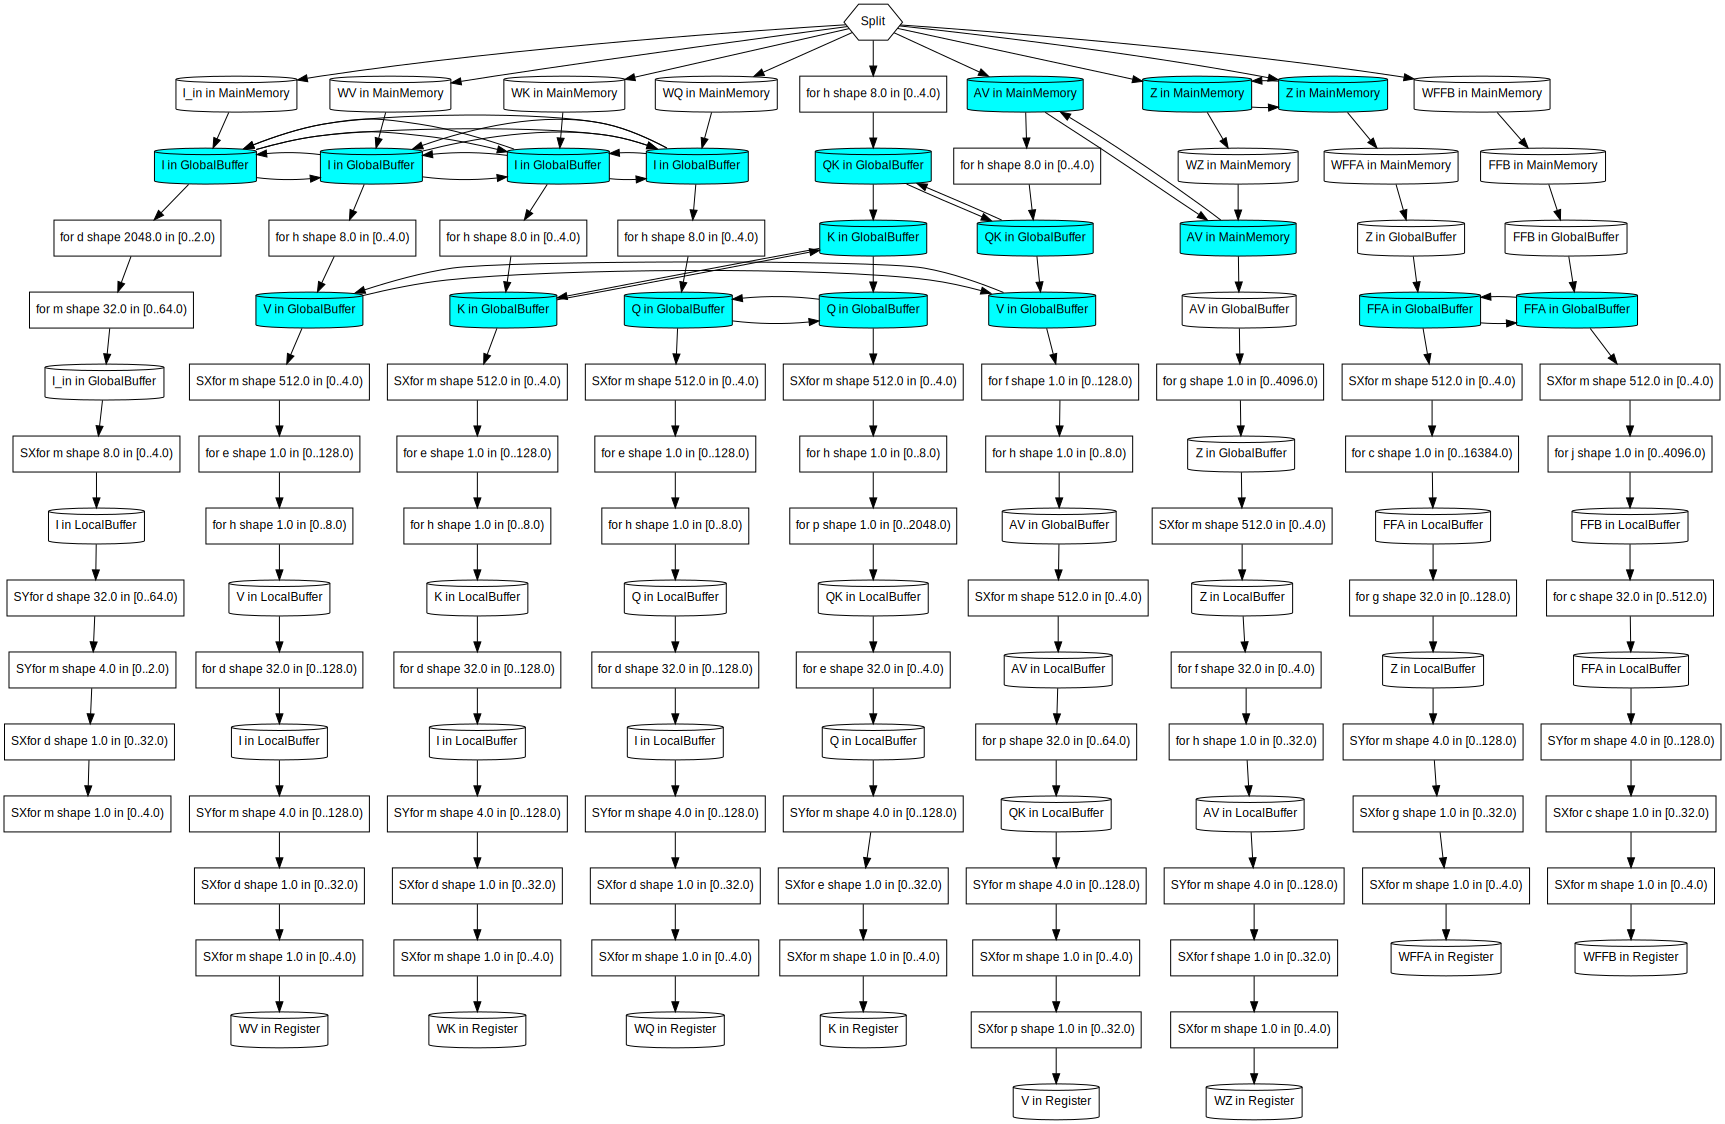

In [5]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

sram_size = 4 * 1024 * 1024 * 8
llb = CactiSRAM(technology="7nm", width=128, depth=sram_size // 128)
mac_dims = int((((area_budget - glb.get_area()) / 4 - llb.get_area()) / mac_area)** 0.5)
mappings = get_fused_mappings(
    spec,
    mac_dims,
    llb,
    glb,
    return_mappings=True,
    parameterization="FFM"
)
mappings._data = mappings.data.sort_values(by="metric_Latency", ascending=True).head()
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
a = {}
for col in mappings.data.columns:
    print(f'{col}: {mappings.data.iloc[0][col]}')
    if "Latency" in col:
        a[col] = mappings.data.iloc[0][col]
display(SVG(newmapping.render()))

In [ ]:
from fastfusion.mapper.FFM.exploration.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

sram_size = 0.5 * 1024 * 1024 * 8
llb = CactiSRAM(technology="7nm", width=128, depth=sram_size // 128)
mac_dims = int((((area_budget - glb.get_area()) / 4 - llb.get_area()) / mac_area)** 0.5)
mappings = get_fused_mappings(
    spec,
    mac_dims,
    llb,
    glb,
    return_mappings=True,
    parameterization="FFM"
)
mappings._data = mappings.data.sort_values(by="metric_Latency", ascending=True).head()
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
from fastfusion.mapper.FFM.visualization import make_mapping
from IPython.display import SVG
newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
b = {}
for col in mappings.data.columns:
    print(f'{col}: {mappings.data.iloc[0][col]}')
    if "Latency" in col:
        b[col] = mappings.data.iloc[0][col]
display(SVG(newmapping.render()))

INFO        Calculated "614e9 * 8 / 1.05e9" = 4678.0952380952385.
INFO        Calculated "0.84e-12 / 8" = 1.05e-13.
INFO        Calculated "0.5" = 0.5.


By default metrics optimizes for energy and latency.We should change to just energy or just latency at some point.


Generating storage and loop choices for Einsum I: 12it [00:00, 143.57it/s]
Generating Pmappings for I: 100%|██████████| 12/12 [00:00<00:00, 4929.16it/s]


0 / 144 skipped (0.00%)
0 / 144 skipped (0.00%)
0 / 144 skipped (0.00%)
0 / 144 skipped (0.00%)
0 / 144 skipped (0.00%)
0 / 144 skipped (0.00%)
0 / 2333 skipped (0.00%)
0 / 2333 skipped (0.00%)
0 / 2426 skipped (0.00%)
0 / 2426 skipped (0.00%)
0 / 2426 skipped (0.00%)
0 / 2333 skipped (0.00%)


Generating storage and loop choices for Einsum V: 28it [00:00, 218.87it/s]
Generating Pmappings for V: 100%|██████████| 28/28 [00:00<00:00, 20956.55it/s]


Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'MainMemory', 0)}), tags=Tags(({})) because it is not in any tensor2boundless_compatibilities
Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'MainMemory', 0)}), tags=Tags(({})) because it is not in any tensor2boundless_compatibilities
Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'MainMemory', 0)}), tags=Tags(({})) because it is not in any tensor2boundless_compatibilities
Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'MainMemory', 0)}), tags=Tags(({})) because it is not in any tensor2boundless_compatibilities
Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'MainMemory', 0)}), tags=Tags(({})) because it is not in any tensor2boundless_compatibilities
Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'MainMemory', 0)}), tags=Tags(({})) because it is not in any tensor2boundless_compatibilities
Skipping Compatibility(loops=(), storage={Reservation('I', 0, 'M

In [ ]:
df = pd.DataFrame([a, b])
df